In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score
import tensorflow as tf

In [ ]:
disaster_cat = pd.read_csv("/content/drive/My Drive/Project corpus/disaster_categories.csv")
disaster_msg = pd.read_csv("/content/drive/My Drive/Project corpus/disaster_messages.csv")

In [ ]:
frames = [disaster_cat,disaster_msg['id'],disaster_msg['message']]
data = pd.concat(frames, axis=1)
del data['id']

In [ ]:
categories = data['categories'].str.split(pat=';', n=None, expand=True)

In [ ]:
category_colnames = categories.iloc[0].str[:-2]
categories.columns = category_colnames
for column in categories:
    categories[column] = categories[column].str[-1].astype(int)

In [ ]:
#combine the available topics to generate new

categories['medical_and_other_aids'] = categories.aid_related | categories.medical_help | categories.medical_products | categories.other_aid | categories.aid_centers | categories.hospitals
categories['army_and_police'] = categories.security | categories.military
categories['needs'] = categories.water | categories.food 
categories['disasters'] = categories.weather_related | categories.other_weather
categories['infrastructure'] = categories.infrastructure_related | categories.transport | categories.buildings | categories.electricity | categories.tools | categories.shops | categories.other_infrastructure

In [ ]:
df = data.drop(columns='categories')
df = pd.concat([df, categories.related, categories.medical_and_other_aids, categories.army_and_police, categories.needs, categories.disasters, categories.infrastructure, categories.search_and_rescue, categories.child_alone, categories.shelter, categories.clothing, categories.money, categories.missing_people, categories.refugees,categories.death, categories.floods, categories.storm, categories.fire, categories.earthquake, categories.cold],axis=1)
df = df[df['related'] == 1]
df = df.drop_duplicates(keep='first')

In [ ]:
df = df.iloc[:,df.columns != 'related']

In [ ]:
df.head()

,message,medical_and_other_aids,army_and_police,needs,disasters,infrastructure,search_and_rescue,child_alone,shelter,clothing,money,missing_people,refugees,death,floods,storm,fire,earthquake,cold
0,Weather update - a cold front from Cuba that c...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Is the Hurricane over or is it not over,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,Looking for someone but no name,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,UN reports Leogane 80-90 destroyed. Only Hospi...,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,"says: west side of Haiti, rest of the country ...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

for i in range(len(df)):
  try:
    df["message"][i] = re.sub(r'http[s]?[ ]?:[ ]?//\S+', '', df["message"][i].lower())
    df["message"][i] = re.sub(r'[^a-zA-Z ]', '', df["message"][i])
    # data["message"][i] = re.sub("burn|blaze", "fire", data["message"][i])
  except KeyError:
    continue
    
reg_tokenizer = RegexpTokenizer(r'\w+')
lemmatizer = WordNetLemmatizer()
stop_words = stopwords.words("english")
stop_words.extend(['news', 'report', 'affect' ,'say','use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do','took','time','year', 'people', 'heavy', 'government', 'done', 'try', 'many', 'some','nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line','even', 'also', 'may', 'take', 'come', 'new','said', 'like','people','sex','fuck','good','dance'])


df["tokenized"] = df["message"].apply(reg_tokenizer.tokenize)
df["tokenized"] = df["tokenized"].apply(lambda x: [w for w in x if w not in stop_words])  
df["tokenized"] = df["tokenized"].apply(lambda x: [stemmer.stem(i) for i in x])
df["tokenized"] = df["tokenized"].apply(lambda x: [lemmatizer.lemmatize(i) for i in x])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [ ]:
df.tail()

,message,medical_and_other_aids,army_and_police,needs,disasters,infrastructure,search_and_rescue,child_alone,shelter,clothing,money,missing_people,refugees,death,floods,storm,fire,earthquake,cold,tokenized
26240,The delivery was made in conjunction with the ...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"[the, deliveri, made, conjunct, wfp, staffer, ..."
26242,"Hpakant, an area rich with coveted jade stones...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"[hpakant, area, rich, covet, jade, stone, seen..."
26245,"Proshika, operating in Cox's Bazar municipalit...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"[proshika, oper, cox, bazar, municip, 5, union..."
26246,"Some 2,000 women protesting against the conduc...",1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"[some, 2, 000, woman, protest, conduct, elect,..."
26247,A radical shift in thinking came about as a re...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"[a, radic, shift, think, came, result, meet, r..."


In [ ]:
df_final = df.loc[:,df.columns != 'message']

In [ ]:
for i in range (26248):
  try:
    df_final['tokenized'][i] = ' '.join(df_final['tokenized'][i])
  except KeyError:
    continue

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
df_final.tail()

,medical_and_other_aids,army_and_police,needs,disasters,infrastructure,search_and_rescue,child_alone,shelter,clothing,money,missing_people,refugees,death,floods,storm,fire,earthquake,cold,tokenized
26240,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,the deliveri made conjunct wfp staffer rent tr...
26242,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,hpakant area rich covet jade stone seen recent...
26245,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,proshika oper cox bazar municip 5 union ramu c...
26246,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,some 2 000 woman protest conduct elect teargas...
26247,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,a radic shift think came result meet recogn hi...


In [ ]:
y = df_final.iloc[:, :-1].values
X = df_final['tokenized']

In [ ]:
len(y[0])

18

In [ ]:
X

0                  weather updat cold front cuba pas haiti
1                                                 hurrican
2                                         look someon name
3        un report leogan destroy hospit st croix funct...
4           say west side haiti rest countri today tonight
                               ...                        
26240    the deliveri made conjunct wfp staffer rent tr...
26242    hpakant area rich covet jade stone seen recent...
26245    proshika oper cox bazar municip 5 union ramu c...
26246    some 2 000 woman protest conduct elect teargas...
26247    a radic shift think came result meet recogn hi...
Name: tokenized, Length: 19896, dtype: object

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)

In [ ]:
X_train

9063             plea put card just call someon got exig u
4553            la plain zone call marin havent gotten aid
25040    israel resort excess forc respond second intifada
22907    a shortag fuel leav altern drink unboil water ...
13119    sprint fuckin trash servic horribl sinc sandi ...
                               ...                        
15738    valley toward snowi peak mark start himalaya t...
21314    390 000 addit access improv water sourc househ...
19284    due instal hydroelectr power station countri d...
19355              landmin deton vehicl occup escap unharm
15801    like occur period warm southwest wester wind a...
Name: tokenized, Length: 15916, dtype: object

In [ ]:
from keras.preprocessing.text import Tokenizer
import pickle

max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train))
list_tokenized_train = tokenizer.texts_to_sequences(X_train)
list_tokenized_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers


In [ ]:
maxlen = 50
X_tr = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

In [ ]:
X_tr

array([[   0,    0,    0, ...,  379, 9254,    7],
       [   0,    0,    0, ...,  431, 1262,   18],
       [   0,    0,    0, ...,  539,  551, 9255],
       ...,
       [   0,    0,    0, ...,  950,  146,  163],
       [   0,    0,    0, ..., 2338, 1374, 5628],
       [   0,    0,    0, ..., 1744,  155, 5819]], dtype=int32)

## model

In [ ]:
inp = Input(shape=(maxlen, ))

In [ ]:
embed_size = 128
x = Embedding(max_features, embed_size)(inp)

In [ ]:
x = LSTM(60, return_sequences=True,name='lstm_layer')(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(18, activation="sigmoid")(x)

In [ ]:
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [ ]:
batch_size = 32
epochs = 20
history = model.fit(X_tr,y_train, batch_size=batch_size, epochs=epochs)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/20
15916/15916 [==============================] - 32s 2ms/step - loss: 0.2868 - accuracy: 0.8915
Epoch 2/20
15916/15916 [==============================] - 31s 2ms/step - loss: 0.2170 - accuracy: 0.9216
Epoch 3/20
15916/15916 [==============================] - 31s 2ms/step - loss: 0.1898 - accuracy: 0.9314
Epoch 4/20
15916/15916 [==============================] - 32s 2ms/step - loss: 0.1675 - accuracy: 0.9397
Epoch 5/20
15916/15916 [==============================] - 31s 2ms/step - loss: 0.1489 - accuracy: 0.9463
Epoch 6/20
15916/15916 [==============================] - 32s 2ms/step - loss: 0.1348 - accuracy: 0.9515
Epoch 7/20
15916/15916 [==============================] - 32s 2ms/step - loss: 0.1216 - accuracy: 0.9565
Epoch 8/20
15916/15916 [==============================] - 32s 2ms/step - loss: 0.1102 - accuracy: 0.9606
Epoch 9/20
15916/15916 [==============================] - 32s 2ms/step - loss: 0.1004 - accuracy: 0.9642
Epoch 10/20
15916/15916 [==============================

In [ ]:
loss, acc = model.evaluate(X_te, y_test)
print()
print("Test accuracy = ", acc)

3980/3980 [==============================] - 1s 250us/step

Test accuracy =  0.9219850897789001


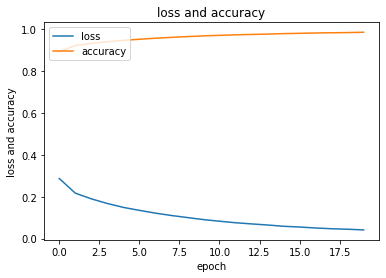

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['accuracy'])
plt.title('loss and accuracy')
plt.ylabel('loss and accuracy')
plt.xlabel('epoch')
plt.legend(['loss','accuracy'], loc='upper left')
plt.show()

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 50)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 50, 128)           2560000   
_________________________________________________________________
lstm_layer (LSTM)            (None, 50, 60)            45360     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 60)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                3050      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0   

In [ ]:
category_names = (df_final.columns[:-1]).tolist()

In [ ]:
import pickle

loaded_model = pickle.load(open('/content/drive/My Drive/Project corpus/models/RNN_18cat_1_20.pickle', 'rb'))
tokenizer_rnn = pickle.load(open('/content/drive/My Drive/Project corpus/models/tokenizer_18.pickle', 'rb'))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [ ]:
category_names

['medical_and_other_aids',
 'army_and_police',
 'needs',
 'disasters',
 'infrastructure',
 'search_and_rescue',
 'child_alone',
 'shelter',
 'clothing',
 'money',
 'missing_people',
 'refugees',
 'death',
 'floods',
 'storm',
 'fire',
 'earthquake',
 'cold']

In [ ]:
reg_tokenizer = RegexpTokenizer(r'\w+')
lemmatizer = WordNetLemmatizer()

s = "I am having a heart attack"
s = re.sub(r'http[s]?[ ]?:[ ]?//\S+', '', s.lower())
s = re.sub(r'[^a-zA-Z ]', '', s)
s = reg_tokenizer.tokenize(s)
s = [w for w in s if w not in stop_words]
s = [stemmer.stem(i) for i in s]
s = [lemmatizer.lemmatize(i) for i in s]

In [ ]:
s = [' '.join(s)]

In [ ]:
list_tokenized_sample = tokenizer_rnn.texts_to_sequences(s)
X_sample = pad_sequences(list_tokenized_sample, maxlen=maxlen)
result2 = loaded_model.predict(X_sample)

In [ ]:
print(s)

['heart attack']


In [ ]:
res = sorted(range(len(result2[0])), key = lambda sub: result2[0][sub])[-5:] 
print('filtered from top 5')
for i in res:
  if result2[0][i] > 0.3:
    print(category_names[i],result2[0][i])
print()
print (result2)

filtered from top 5
medical_and_other_aids 0.8100438

[[8.1004381e-01 1.5337014e-01 2.4705934e-05 8.0460310e-04 3.9571226e-03
  3.5444200e-03 4.2317504e-11 2.4571941e-06 4.6743239e-06 4.2095240e-07
  3.5882294e-03 2.5099516e-04 4.6758950e-03 1.1893262e-05 1.0097179e-06
  1.4716387e-04 3.9441999e-05 1.8202493e-07]]
